#### Importing packages

In [42]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
import plotly as py
import plotly.express as px
import missingno as msno
from sklearn.impute import KNNImputer
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import plot_roc_curve
from sklearn.metrics import accuracy_score
# to avoid warnings
import warnings
warnings.filterwarnings('ignore')
warnings.warn("this will not show")

#### Functions

In [43]:
# Function to remove missing values above a given threshold
def missing_remove(dataframe, threshold):
    columns = dataframe.columns[(dataframe.isna().sum()/dataframe.shape[1])>threshold].tolist()
    print(f"# Features deleted with more than {threshold} % missing values", len(columns))
    return dataframe.drop(columns, axis=1,inplace=True)

In [44]:
# Function to remove features with unique values
def unique_remove(dataframe):
    unique_features = []
    for col in dataframe.columns:
        if(dataframe[col].unique().size == 2):
            if(len(unique_features) == 0):
                unique_features =  dataframe[col]
            else:
                 unique_features = pd.concat([unique_features, dataframe[col]], axis=1)
            dataframe.drop(col, axis=1, inplace=True)

In [45]:
# Function to remove outlier
def outlier_detection_zcore(dataframe):
    data_mean, data_std  = dataframe.mean(), dataframe.std()
    data_z_scores = ((dataframe - data_mean) / data_std).abs()
    m = data_z_scores > 3
    dataframe = dataframe.mask(m,inplace=True)
    return dataframe

In [46]:
def evaluate2(model, X_train,X_test,y_train,y_test):
  from matplotlib.pyplot import figure
  figure(figsize=(8, 5), dpi=80)

  scaler = StandardScaler()
  scaler.fit(X_train)
  X_train_std = pd.DataFrame(scaler.transform(X_train), columns=X_train.columns)
  X_test_std = pd.DataFrame(scaler.transform(X_test), columns=X_test.columns)

  model.fit(X_train_std, y_train)
  y_pred = model.predict(X_test_std)
  cm=confusion_matrix(y_test, y_pred)
  sns.heatmap(cm, annot=True, fmt="d",cmap="YlOrRd",yticklabels = ['Act. Pass', 'Act. Fail'], xticklabels = ['Pred. Pass' , 'Pred. Fail'])
  #print(classification_report(y_test, y_pred))
  ax = plt.gca()
  plot = plot_roc_curve(model, X_test_std, y_test, ax=ax, alpha=0.8)
  print("Model Name:", model)
  print("Train Accuracy Score:", accuracy_score(y_train, model.predict(X_train_std)))
  print("Test Accuracy Score:", accuracy_score(y_test, y_pred))
  f1score = f1_score(y_test, y_pred, average='micro')
  mccscore=matthews_corrcoef(y_test, y_pred)
  recall = recall_score(y_test,y_pred)
  precision = precision_score(y_test,y_pred)
  specificity = cm[1,1]/(cm[1,1]+cm[0,1])
  sensitivity = cm[0,0]/(cm[0,0]+cm[1,0])
  FNR = cm[1,0]/(cm[1,0]+cm[0,0])
  FPR = cm[0,1]/(cm[0,1]+cm[1,1])
  specificity1 = 1 - FPR
  sensitivity1 = 1- FNR
  print("F1 Score:", f1score) 
  print("MC Score:" , mccscore)
  print("Sensitivity:" , sensitivity)
  print("Specificity:" , specificity)
  print("Recall:" , recall)
  print("Precision:" , precision)
  print("FNR:" , FNR)
  print(f"FPR: {FPR}\n" )
  #print("Sensitivity1:" , sensitivity1)
  #print("Specificity1:" , specificity1)

In [47]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import f1_score, matthews_corrcoef
from yellowbrick.classifier import ConfusionMatrix, ClassPredictionError
def evaluate(train_df, test_df, train_target, test_target):
    
    scaler = StandardScaler()
    scaler.fit(train_df)
    train_std = pd.DataFrame(scaler.transform(train_df), columns=train_df.columns)
    test_std = pd.DataFrame(scaler.transform(test_df), columns=test_df.columns)
    
    logreg = LogisticRegression(random_state = 42, class_weight='balanced', C=200, dual=False, solver='liblinear')
    logreg.fit(train_std, train_target.values.ravel())
    
    y_pred = logreg.predict(test_std)
    y_true = test_target.values.ravel()
    f1score = f1_score(y_true, y_pred, average='micro')
    mccscore=matthews_corrcoef(y_true, y_pred)
    
   
    cm = ConfusionMatrix(logreg, classes=['Fail', 'Pass'], cmap="YlGn", size=(400,400))
    cm.score(test_std, y_true)
    cm.show()
    from matplotlib.pyplot import figure
    figure(figsize=(5, 5), dpi=80)
    ax = plt.gca()
    plot = plot_roc_curve(logreg, test_df, test_target, ax=ax, alpha=0.8)
    
    return f1score, mccscore

#### Importing and basic cleaning

In [48]:
# Importing data from internet in runtime
data_url="https://archive.ics.uci.edu/ml/machine-learning-databases/secom/secom.data"

In [49]:
# Assigning data to a pandas dataframe
secom_data = pd.read_csv(data_url,sep=' ',header=None)

In [50]:
# Renaming the columns 
secom_data.columns = ["Feature_"+str(column+1) for column in range(len(secom_data.columns))]
secom_data.head()

,Feature_1,Feature_2,Feature_3,Feature_4,Feature_5,Feature_6,Feature_7,Feature_8,Feature_9,Feature_10,...,Feature_581,Feature_582,Feature_583,Feature_584,Feature_585,Feature_586,Feature_587,Feature_588,Feature_589,Feature_590
0,3030.93,2564.00,2187.7333,1411.1265,1.3602,100.0,97.6133,0.1242,1.5005,0.0162,...,NaN,NaN,0.5005,0.0118,0.0035,2.3630,NaN,NaN,NaN,NaN
1,3095.78,2465.14,2230.4222,1463.6606,0.8294,100.0,102.3433,0.1247,1.4966,-0.0005,...,0.0060,208.2045,0.5019,0.0223,0.0055,4.4447,0.0096,0.0201,0.0060,208.2045
2,2932.61,2559.94,2186.4111,1698.0172,1.5102,100.0,95.4878,0.1241,1.4436,0.0041,...,0.0148,82.8602,0.4958,0.0157,0.0039,3.1745,0.0584,0.0484,0.0148,82.8602
3,2988.72,2479.90,2199.0333,909.7926,1.3204,100.0,104.2367,0.1217,1.4882,-0.0124,...,0.0044,73.8432,0.4990,0.0103,0.0025,2.0544,0.0202,0.0149,0.0044,73.8432
4,3032.24,2502.87,2233.3667,1326.5200,1.5334,100.0,100.3967,0.1235,1.5031,-0.0031,...,NaN,NaN,0.4800,0.4766,0.1045,99.3032,0.0202,0.0149,0.0044,73.8432


In [51]:
# Importing target data from internet in runtime
label_url="https://archive.ics.uci.edu/ml/machine-learning-databases/secom/secom_labels.data"

In [52]:
# Assigning target data to a pandas dataframe
secom_labels = pd.read_csv(label_url, sep = " ",header=None)

In [53]:
# Renaming the columns 
secom_labels.columns = ["Classification","Timestamp"]

In [54]:
# Changing datatype for consitency
secom_labels['Timestamp'] = pd.to_datetime(secom_labels['Timestamp'],errors='raise')

In [55]:
# Merging the data
data= pd.concat([secom_labels,secom_data],axis=1)

In [56]:
# Dropping the timestamp column as it provides no insights
data.drop(columns="Timestamp", errors='raise',inplace=True)

In [57]:
target = data[['Classification']]
data.drop(['Classification'], axis=1,inplace=True)

#### Spliting the data into training set and test set

In [58]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(data,target, test_size=0.20, random_state=42, stratify=target)
# We use the startify parameter as the data is imbalanced on the basis of pass and fail and this will ensure the same 
#is retained when we split - Random state will help us create a reproducible data - Test size is the split ration

In [59]:
X_test_original = X_test

#### Re-labeling the Target values


In [60]:
# Relabeling target variables 1 is pass and 0 is fail
# y_train = y_train.replace(to_replace=[-1, 1], value=[1, 0])
# y_test = y_test.replace(to_replace=[-1, 1], value=[1, 0])

In [61]:
# # Scaling the data
# scaler = StandardScaler()
# scaler.fit(X_train)
# X_train = pd.DataFrame(scaler.transform(X_train), columns=X_train.columns)
# X_test = pd.DataFrame(scaler.transform(X_test), columns=X_test.columns)

# Decision : Removing columns with more that 50% missing values

In [62]:
X_train.shape

(1253, 590)

In [63]:
X_train_missing = X_train
missing_remove(X_train_missing, 0.5)
X_train_missing.shape

# Features deleted with more than 0.5 % missing values 32


(1253, 558)

In [64]:
# From test set deleting columns that are removed in training set
X_test_missing = X_test[np.array(X_train_missing.columns)]
X_test_missing.shape

(314, 558)

# Decision : Replacing outliers with 3s boundary

##### Other option of removing outliers and replacing them has been explored in file "Base file - removing outliers and replacing with knn.ipynb"

In [65]:
def replace_outlier(val, mean, std):
    if val > mean + 3*std:
        return mean + 3*std 
    elif val < mean - 3*std:
        return mean - 3*std
    return val

In [66]:
# replace with 3s in X_train
for col in X_train_missing.columns:
    mean = X_train_missing[col].mean()
    std_dev = X_train_missing[col].std(axis=0)
    X_train_missing[col] = X_train_missing[col].map(lambda x: replace_outlier(x, mean, std_dev))

In [67]:
# replace with 3s in X_test
for col in X_test_missing.columns:
    mean = X_test_missing[col].mean()
    std_dev = X_test_missing[col].std(axis=0)
    X_test_missing[col] = X_test_missing[col].map(lambda x: replace_outlier(x, mean, std_dev))

# KNN Imputation

In [68]:
from sklearn.impute import KNNImputer
knn = KNNImputer()
knn.fit(X_train_missing)
X_train_knn=pd.DataFrame(knn.transform(X_train_missing), columns=X_train_missing.columns)
X_train_knn.isna().sum().sum()

0

In [69]:
from sklearn.impute import KNNImputer
knn = KNNImputer()
knn.fit(X_test_missing)
X_test_knn=pd.DataFrame(knn.transform(X_test_missing), columns=X_test_missing.columns)
X_test_knn.isna().sum().sum()

0

# Feature Selection

## Forward Feature Selection

In [70]:
#importing the necessary libraries
from mlxtend.feature_selection import SequentialFeatureSelector as SFS
from sklearn.linear_model import LinearRegression
# Sequential Forward Selection(sfs)
sfs = SFS(LinearRegression(),k_features=25,forward=True,verbose=True,scoring='neg_mean_squared_error')

In [71]:
sfs.fit(X_train_knn, y_train)
sfs_list = list(sfs.k_feature_names_)
print(sfs_list)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 558 out of 558 | elapsed:    8.8s finished
Features: 1/25[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 557 out of 557 | elapsed:    8.2s finished
Features: 2/25[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 556 out of 556 | elapsed:    8.6s finished
Features: 3/25[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 555 out of 555 | elapsed:    8.7s finished
Features: 4/25[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 554 out of 554 | elapsed:    8.9s finished
Features: 5/25[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 553 out of 553 | elapsed:    9.0s finished
Features: 6/25[Parallel(

['Feature_20', 'Feature_22', 'Feature_52', 'Feature_60', 'Feature_65', 'Feature_76', 'Feature_87', 'Feature_104', 'Feature_105', 'Feature_114', 'Feature_122', 'Feature_130', 'Feature_133', 'Feature_206', 'Feature_282', 'Feature_311', 'Feature_318', 'Feature_320', 'Feature_388', 'Feature_434', 'Feature_481', 'Feature_485', 'Feature_512', 'Feature_542', 'Feature_574']


In [72]:
# creating a new dataframe using the above variables and adding the target variable
X_train_sfs = X_train_knn[sfs_list]

In [73]:
# From test set deleting columns that are removed in training set
X_test_sfs = X_test_knn[np.array(X_train_sfs.columns)]
X_test_sfs.shape

(314, 25)

<AxesSubplot:>

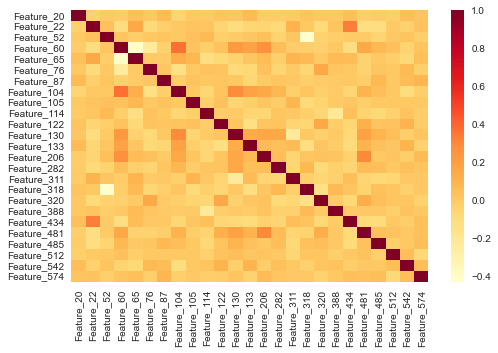

In [74]:
import seaborn as sns
# Heatmap for correlation
plt.rcParams['figure.figsize'] = (8,5)
sns.heatmap(X_train_sfs.corr(),cmap="YlOrRd")
#plt.title('Heatmap for the Data', fontsize = 50)

## Balancing usnig SMOTE

In [75]:
import numpy as np
from imblearn.over_sampling import SMOTE, ADASYN, RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler
from sklearn.decomposition import PCA

In [76]:
from imblearn.combine import SMOTETomek 
# Sampling technique

def Sampling(X_train, y_train, sampler):

    #SMOTE
    if sampler == 'SMOTE':
        sampler = SMOTE(random_state=100)    
    

     #ADASYN
    if sampler == 'ADASYN':
        sampler = ADASYN(random_state=100)
        
    #ROSE
    if sampler == 'ROSE':
        sampler = RandomOverSampler(random_state=100, shrinkage=1)
        

    X_resampled, y_resampled = sampler.fit_resample(X_train, y_train)
    counter = Counter(y_resampled)
    print(counter)
    return X_resampled, y_resampled

In [77]:
# Imbalance treatment
from collections import Counter
X_smote, y_smote = Sampling(X_train_sfs, y_train,'SMOTE')

Counter({'Classification': 1})


Model Name: LogisticRegression(C=200, class_weight='balanced', random_state=42,
                   solver='liblinear')
Train Accuracy Score: 0.8145299145299145
Test Accuracy Score: 0.7834394904458599
F1 Score: 0.7834394904458599
MC Score: 0.1965908642237386
Sensitivity: 0.9591836734693877
Specificity: 0.15942028985507245
Recall: 0.5238095238095238
Precision: 0.15942028985507245
FNR: 0.04081632653061224
FPR: 0.8405797101449275

Model Name: RandomForestClassifier(class_weight='balanced_subsample', max_depth=6,
                       n_jobs=-1, random_state=100)
Train Accuracy Score: 0.964957264957265
Test Accuracy Score: 0.8885350318471338
F1 Score: 0.8885350318471338
MC Score: 0.25992997448744265
Sensitivity: 0.954225352112676
Specificity: 0.26666666666666666
Recall: 0.38095238095238093
Precision: 0.26666666666666666
FNR: 0.045774647887323945
FPR: 0.7333333333333333

Model Name: SVC()
Train Accuracy Score: 0.9880341880341881
Test Accuracy Score: 0.8726114649681529
F1 Score: 0.8726114649

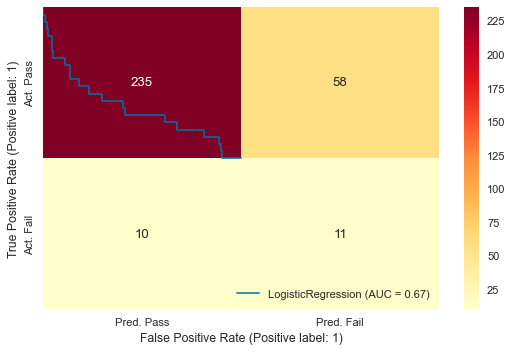

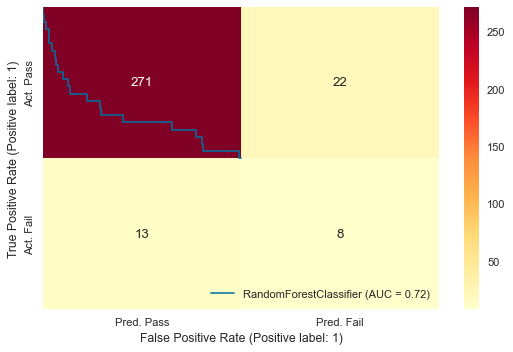

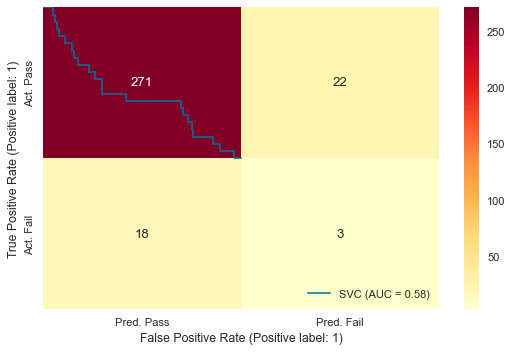

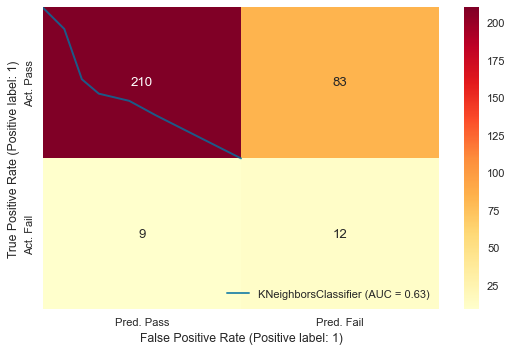

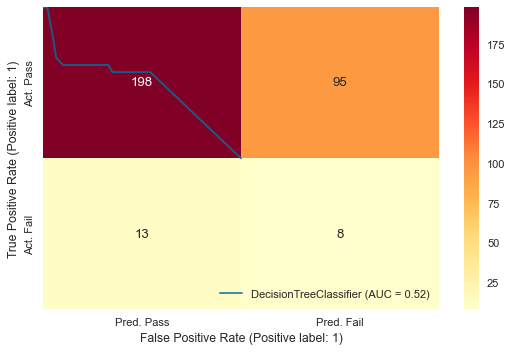

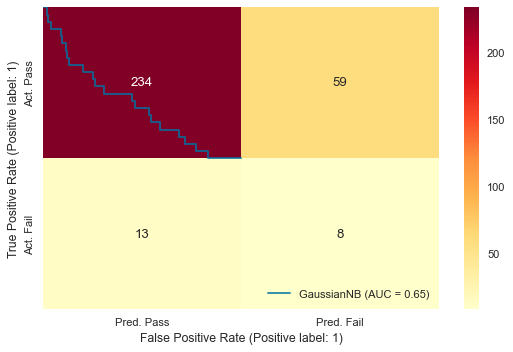

In [78]:
from sklearn import svm
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.model_selection import cross_val_score
from sklearn.metrics import plot_confusion_matrix, classification_report, confusion_matrix
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import accuracy_score,recall_score, precision_score


evaluate2(LogisticRegression(random_state = 42, class_weight='balanced', C=200, dual=False, solver='liblinear'),X_smote,X_test_sfs,y_smote,y_test)
evaluate2(RandomForestClassifier(n_jobs=-1, class_weight='balanced_subsample', max_depth=6, random_state=100),X_smote,X_test_sfs,y_smote,y_test)
evaluate2(svm.SVC(),X_smote,X_test_sfs,y_smote,y_test)
evaluate2(KNeighborsClassifier(n_neighbors=5),X_smote,X_test_sfs,y_smote,y_test)
evaluate2(DecisionTreeClassifier(criterion='entropy', max_depth=6),X_smote,X_test_sfs,y_smote,y_test)
evaluate2(GaussianNB(),X_smote,X_test_sfs,y_smote,y_test)

## Adasyn

In [79]:
# Imbalance treatment
X_adasyn, y_adasyn = Sampling(X_train_sfs, y_train,'ADASYN')

Counter({'Classification': 1})


Model Name: LogisticRegression(C=200, class_weight='balanced', random_state=42,
                   solver='liblinear')
Train Accuracy Score: 0.8068376068376069
Test Accuracy Score: 0.7898089171974523
F1 Score: 0.7898089171974523
MC Score: 0.20285630337997665
Sensitivity: 0.9595141700404858
Specificity: 0.16417910447761194
Recall: 0.5238095238095238
Precision: 0.16417910447761194
FNR: 0.04048582995951417
FPR: 0.835820895522388

Model Name: RandomForestClassifier(class_weight='balanced_subsample', max_depth=6,
                       n_jobs=-1, random_state=100)
Train Accuracy Score: 0.9606837606837607
Test Accuracy Score: 0.8662420382165605
F1 Score: 0.8662420382165607
MC Score: 0.18874034508940588
Sensitivity: 0.9498207885304659
Specificity: 0.2
Recall: 0.3333333333333333
Precision: 0.2
FNR: 0.05017921146953405
FPR: 0.8

Model Name: SVC()
Train Accuracy Score: 0.9888888888888889
Test Accuracy Score: 0.8757961783439491
F1 Score: 0.8757961783439491
MC Score: 0.02640352215340864
Sensitivit

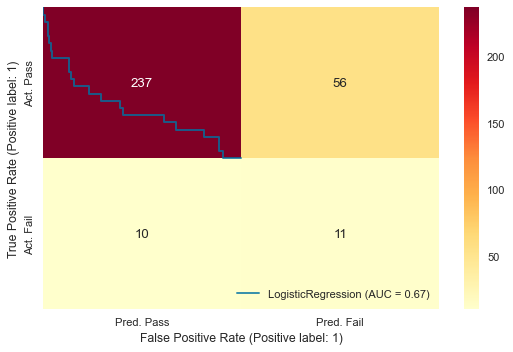

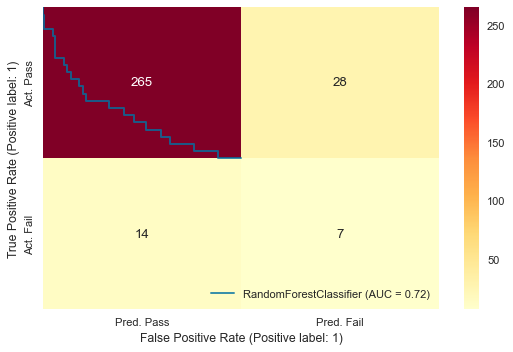

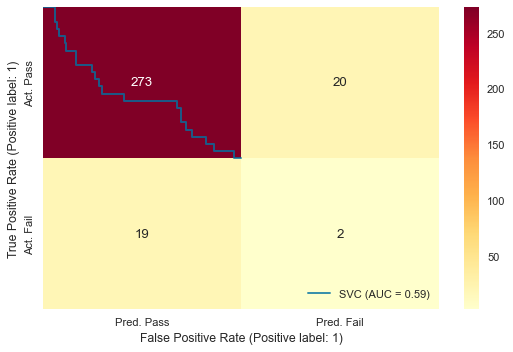

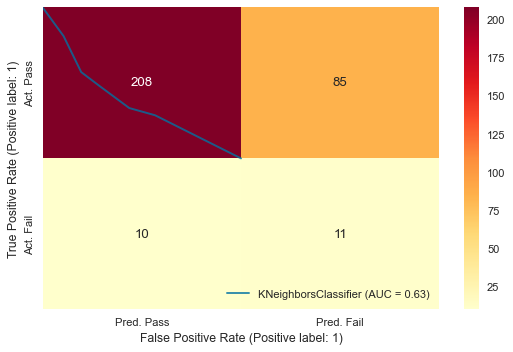

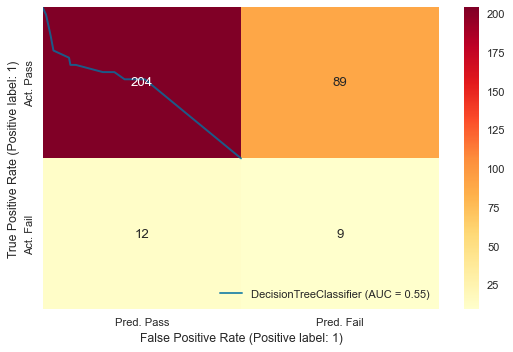

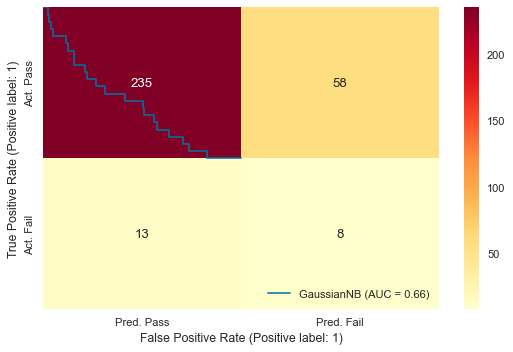

In [80]:
evaluate2(LogisticRegression(random_state = 42, class_weight='balanced', C=200, dual=False, solver='liblinear'),X_adasyn,X_test_sfs,y_adasyn,y_test)
evaluate2(RandomForestClassifier(n_jobs=-1, class_weight='balanced_subsample', max_depth=6, random_state=100),X_adasyn,X_test_sfs,y_adasyn,y_test)
evaluate2(svm.SVC(),X_adasyn,X_test_sfs,y_adasyn,y_test)
evaluate2(KNeighborsClassifier(n_neighbors=5),X_adasyn,X_test_sfs,y_adasyn,y_test)
evaluate2(DecisionTreeClassifier(criterion='entropy', max_depth=6),X_adasyn,X_test_sfs,y_adasyn,y_test)
evaluate2(GaussianNB(),X_adasyn,X_test_sfs,y_adasyn,y_test)

In [81]:
# Imbalance treatment
X_rose, y_rose = Sampling(X_train_sfs, y_train,'ROSE')

Counter({'Classification': 1})


Model Name: LogisticRegression(C=200, class_weight='balanced', random_state=42,
                   solver='liblinear')
Train Accuracy Score: 0.7606837606837606
Test Accuracy Score: 0.7547770700636943
F1 Score: 0.7547770700636943
MC Score: 0.1945512899034736
Sensitivity: 0.9615384615384616
Specificity: 0.15
Recall: 0.5714285714285714
Precision: 0.15
FNR: 0.038461538461538464
FPR: 0.85

Model Name: RandomForestClassifier(class_weight='balanced_subsample', max_depth=6,
                       n_jobs=-1, random_state=100)
Train Accuracy Score: 0.9692307692307692
Test Accuracy Score: 0.9363057324840764
F1 Score: 0.9363057324840764
MC Score: 0.21113099481711137
Sensitivity: 0.9361022364217252
Specificity: 1.0
Recall: 0.047619047619047616
Precision: 1.0
FNR: 0.06389776357827476
FPR: 0.0

Model Name: SVC()
Train Accuracy Score: 0.9551282051282052
Test Accuracy Score: 0.8853503184713376
F1 Score: 0.8853503184713376
MC Score: 0.1567306400638243
Sensitivity: 0.9446366782006921
Specificity: 0.2
Rec

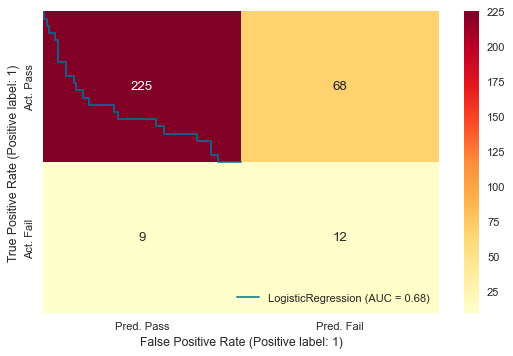

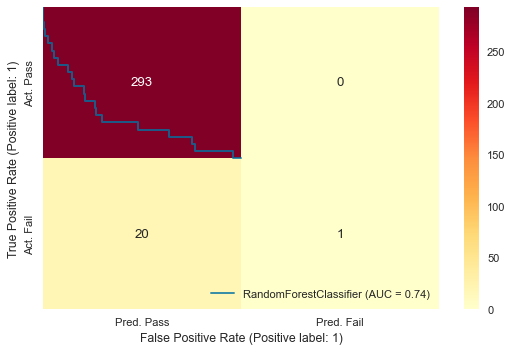

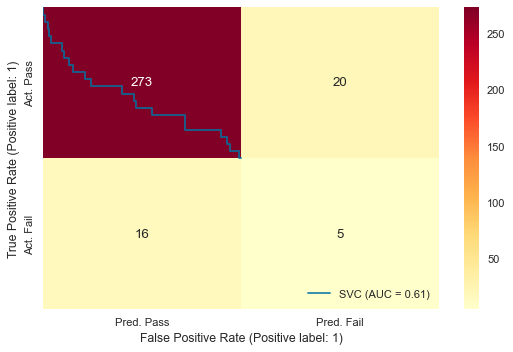

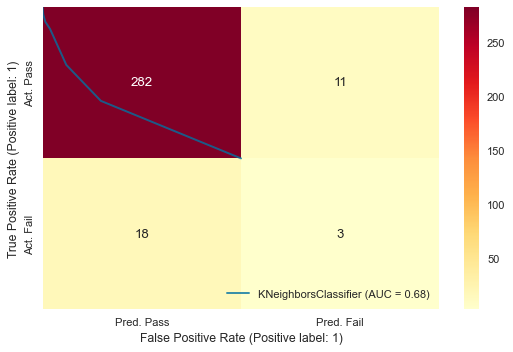

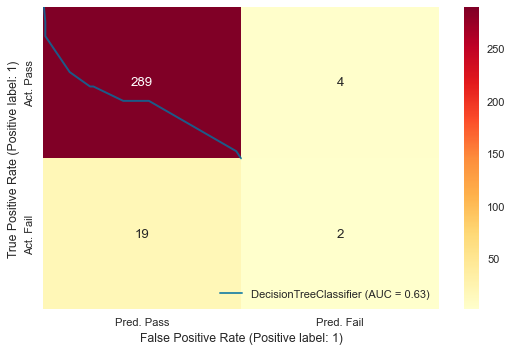

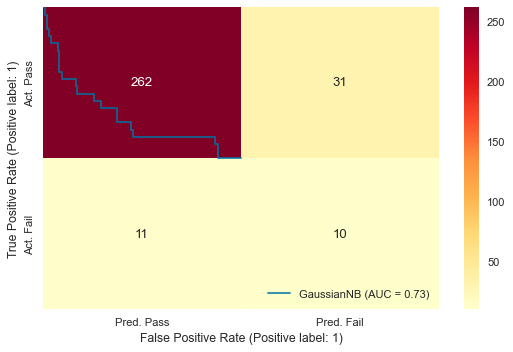

In [82]:
evaluate2(LogisticRegression(random_state = 42, class_weight='balanced', C=200, dual=False, solver='liblinear'),X_rose,X_test_sfs,y_rose,y_test)
evaluate2(RandomForestClassifier(n_jobs=-1, class_weight='balanced_subsample', max_depth=6, random_state=100),X_rose,X_test_sfs,y_rose,y_test)
evaluate2(svm.SVC(),X_rose,X_test_sfs,y_rose,y_test)
evaluate2(KNeighborsClassifier(n_neighbors=5),X_rose,X_test_sfs,y_rose,y_test)
evaluate2(DecisionTreeClassifier(criterion='entropy', max_depth=6),X_rose,X_test_sfs,y_rose,y_test)
evaluate2(GaussianNB(),X_rose,X_test_sfs,y_rose,y_test)


In [89]:
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
# Random forest
params = {'criterion' : ["gini","entropy","log_loss"],
          'max_depth':[4,5,6,7,8,9,10],
         'max_features':["sqrt","log2","auto",None]}
          

grid_searcher = GridSearchCV(RandomForestClassifier(n_estimators=100,random_state=42,n_jobs=-1), params,scoring='roc_auc', cv = 5, verbose=1)
grid_searcher.fit(X_smote, y_smote)

Fitting 5 folds for each of 84 candidates, totalling 420 fits


GridSearchCV(cv=5, estimator=RandomForestClassifier(n_jobs=-1, random_state=42),
             param_grid={'criterion': ['gini', 'entropy', 'log_loss'],
                         'max_depth': [4, 5, 6, 7, 8, 9, 10],
                         'max_features': ['sqrt', 'log2', 'auto', None]},
             scoring='roc_auc', verbose=1)

In [90]:
grid_searcher.best_params_

{'criterion': 'gini', 'max_depth': 10, 'max_features': 'log2'}

Model Name: RandomForestClassifier(max_depth=10, max_features='log2', n_jobs=-1,
                       random_state=42)
Train Accuracy Score: 0.9961538461538462
Test Accuracy Score: 0.9044585987261147
F1 Score: 0.9044585987261147
MC Score: 0.1193556162912239
Sensitivity: 0.939799331103679
Specificity: 0.2
Recall: 0.14285714285714285
Precision: 0.2
FNR: 0.06020066889632107
FPR: 0.8



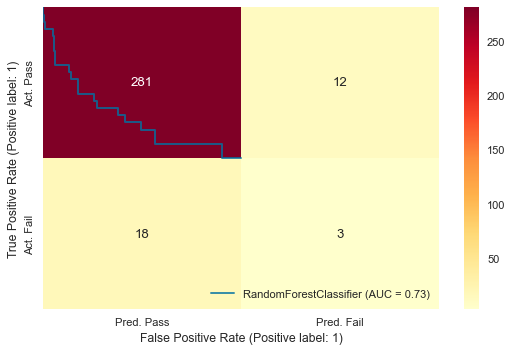

In [91]:
evaluate2(grid_searcher.best_estimator_,X_smote,X_test_sfs,y_smote,y_test)

<AxesSubplot:>

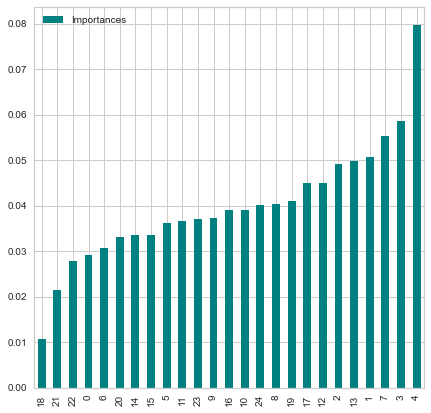

In [83]:
# model = RandomForestClassifier()
# model.fit(X_train_sfs, y_train.values.ravel())
    
# feature_selector = RandomForestClassifier(n_jobs=-1, class_weight='balanced_subsample', max_depth=5, random_state=100)
    
# importances = model.feature_importances_
# final_df = pd.DataFrame({"Features": pd.DataFrame(X_train_sfs).columns, "Importances": importances})
# final_df.set_index('Importances')
# final_df = final_df.sort_values('Importances')
# final_df.plot.bar(color = 'teal',figsize=(7,7))

In [84]:
# # define the tree depths to evaluate
# values = [i for i in range(1, 21)]

In [85]:
# from sklearn.tree import DecisionTreeClassifier
# # evaluate a decision tree for each depth
# test_scores=[]
# train_scores=[]
# for i in values:
#     # configure the model
#     model = RandomForestClassifier(max_depth=i)
#     # fit model on the training dataset
#     model.fit(X_train_sfs, y_train)
#     # evaluate on the train dataset
#     train_yhat = model.predict(X_train_sfs)
#     train_acc = accuracy_score(y_train, train_yhat)
#     train_scores.append(train_acc)
#     # evaluate on the test dataset
#     test_yhat = model.predict(X_test_sfs)
#     test_acc = accuracy_score(y_test, test_yhat)
#     test_scores.append(test_acc)
#     # summarize progress
#     print('%d train: %.3f, test: %.3f' % (i, train_acc, test_acc))

1 train: 0.934, test: 0.933
2 train: 0.934, test: 0.933
3 train: 0.934, test: 0.933
4 train: 0.936, test: 0.933
5 train: 0.939, test: 0.933
6 train: 0.949, test: 0.933
7 train: 0.958, test: 0.933
8 train: 0.964, test: 0.936
9 train: 0.978, test: 0.936
10 train: 0.984, test: 0.933
11 train: 0.994, test: 0.936
12 train: 0.997, test: 0.933
13 train: 0.997, test: 0.933
14 train: 0.999, test: 0.933
15 train: 1.000, test: 0.936
16 train: 1.000, test: 0.933
17 train: 1.000, test: 0.933
18 train: 0.999, test: 0.936
19 train: 1.000, test: 0.936
20 train: 1.000, test: 0.933


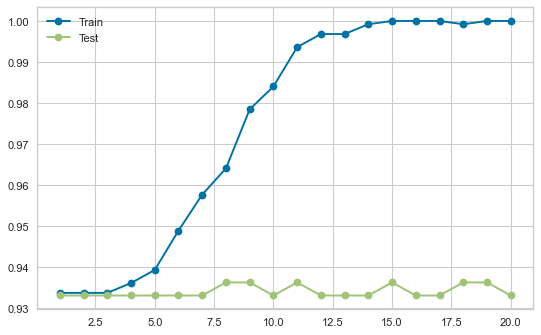

In [86]:
# import matplotlib
# import matplotlib.pyplot as pyplot
# from matplotlib.pyplot import figure
# figure(figsize=(8, 5), dpi=80)
# # plot of train and test scores vs tree depth
# pyplot.plot(values, train_scores, '-o', label='Train')
# pyplot.plot(values, test_scores, '-o', label='Test')
# pyplot.legend()
# pyplot.show()

Text(0.5, 0, 'Random Forest Feature Importance')

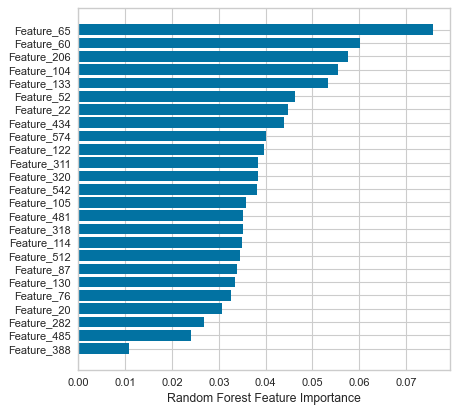

In [87]:
# model = RandomForestClassifier()
# model.fit(X_train_sfs, y_train.values.ravel())
# feature_selector = RandomForestClassifier(n_jobs=-1, class_weight='balanced_subsample', max_depth=5, random_state=100)
# figure(figsize=(6, 6), dpi=80)
# sorted_idx = model.feature_importances_.argsort()
# plt.barh(X_train_sfs.columns[sorted_idx], model.feature_importances_[sorted_idx])
# plt.xlabel("Random Forest Feature Importance")